# Smoke

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Smoke_Plume.ipynb)

This example simulates a rising plume of hot smoke. It demonstrates how to advect and couple other quantities with the fluid.

In [65]:
# %pip install phiflow
from phi.jax.flow import *
from tqdm.notebook import trange
import numpy as np
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.



We begin by defining our simulation size and smoke inflow.

In [ ]:
# Simulation parameters
domain = Box(x=32, y=32)
batch_size = 2 
total_samples = 4
timesteps = 100
inflow_rate = 0.3
inflow_size = 2

def random_inflow_loc(batch_size):
    x = tensor(np.random.uniform(0, 32, size=batch_size), batch('batch_size'))
    y = tensor(np.random.uniform(0, 32, size=batch_size), batch('batch_size'))
    return Sphere(x=x, y=y, radius=inflow_size)

@jit_compile
def step(v, s, p, dt, inflow):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve(x0=p))
    return v, s, p


Our simulation advects the velocity and smoke fields, computes the buoyancy force proportional to the smoke density, and enforces incompressibility.
We sample the velocities on a $64\times 64$ staggered grid, and the smoke density on a $200\times 200$ grid.

In [67]:
all_smoke_trj = []
s_trjs = []
for start in range(0, total_samples, batch_size):
    inflow = random_inflow_loc(batch_size)  # Generate random inflow locations
    v0 = StaggeredGrid(0, 0, domain, x=32, y=32)  # Initialize velocity
    smoke0 = CenteredGrid(0, ZERO_GRADIENT, domain, x=32, y=32)  # Initialize smoke grid

    # Simulate smoke dynamics
    v_trj, s_trj, p_trj = iterate(
        lambda v, s, p, dt: step(v, s, p, dt, inflow),
        batch(time=timesteps),
        v0, smoke0, None,
        dt=1.0
    )
    s_trjs.append(s_trj)
    # Store results for this batch
    # all_smoke_trj.extend([s.values.numpy() for s in s_trj])


    # print(all_smoke_trj)
# `all_smoke_trj` contains smoke data for all 128 samples

In [68]:
s_trjs



[Grid[(timeᵇ=101, batch_sizeᵇ=2, xˢ=32, yˢ=32) 0.073 ± 0.254 (0e+00...3e+00), ext=zero-gradient],
 Grid[(timeᵇ=101, batch_sizeᵇ=2, xˢ=32, yˢ=32) 0.227 ± 0.734 (0e+00...2e+01), ext=zero-gradient]]

In [69]:
plot(s_trjs[0], animate='time', frame_time=80)

In [70]:
plot(s_trjs[1], animate='time', frame_time=80)

In [7]:
s_trjs

[Grid[(timeᵇ=101, settingᵇ=2, xˢ=32, yˢ=32) 0.229 ± 0.758 (0e+00...9e+00), ext=zero-gradient],
 Grid[(timeᵇ=101, settingᵇ=2, xˢ=32, yˢ=32) 0.271 ± 0.600 (0e+00...4e+00), ext=zero-gradient]]

In [49]:
batch_traj = s_trjs[0].numpy('batch_size, time, y, x')

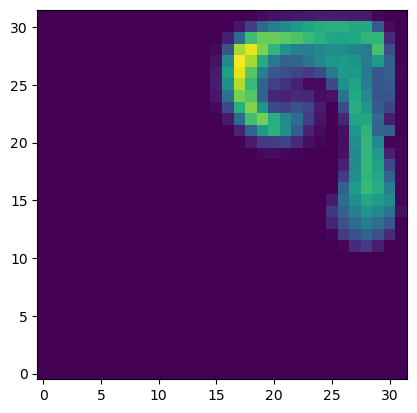

In [53]:
import matplotlib.pyplot as plt
plt.imshow(batch_traj[1][40], origin='lower')